# pronóstico de series de tiempo

En esta notebook vamos a realizar el pronóstico de una serie de tiempo
1. Descargaremos los datos
2. Graficaremos la series para darnos una idea de su comportamiento
3. realizaremos una prueba de raíz unitaria para comprobrar si la serie es estacionaria
4. Diferenciaremos la serie en caso de que no sea estacionaria
5. Realizamos la prueba a la serie diferenciada para ver si es estacionaria
6. Graficaremos la serie estacionaria
7. realizaremos su ACF y PACF para tratar de identificar que tipo de proceso es MA(q), AR(P), ARMA(p,q), etc
8. Estimamos distintos modelos
9. Elegimos el modelo
10. Realizamos el pronóstico 

In [3]:
pip install yfinance

  Created wheel for multitasking: filename=multitasking-0.0.10-py3-none-any.whl size=8500 sha256=2b0ddc774e785230dab56d77c99870806430ba3deea6757777d7d766db7238fc
  Stored in directory: c:\users\merry\appdata\local\pip\cache\wheels\f2\b5\2c\59ba95dcf854e542944c75fe3da584e4e3833b319735a0546c
Successfully built multitasking
Note: you may need to restart the kernel to use updated packages.


In [5]:
# como siempre comenzamos importando las librerias
import numpy as np
import pandas as pd 
import yfinance as yf
import scipy.stats as stats
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA


%matplotlib inline

In [6]:
#fijamos tamaño de graficas
plt.rcParams['figure.figsize'] = [10, 7.5]

## 1. Importamos los datos desde la api de yahoo finance

In [9]:
#recuerda instalar yahoo finance con-> pip install yfinance
apple = yf.download('AAPL', 
                       start='2020-01-01', 
                       end='2022-03-12',
                       progress=False)

In [10]:
#vemos los ultimos 10 datos
apple.tail(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-02-28,163.059998,165.419998,162.429993,165.119995,165.119995,94869100
2022-03-01,164.699997,166.600006,161.970001,163.199997,163.199997,83474400
2022-03-02,164.389999,167.360001,162.949997,166.559998,166.559998,79724800
2022-03-03,168.470001,168.910004,165.550003,166.229996,166.229996,76678400
2022-03-04,164.490005,165.550003,162.100006,163.169998,163.169998,83737200
2022-03-07,163.360001,165.020004,159.039993,159.300003,159.300003,96418800
2022-03-08,158.820007,162.880005,155.800003,157.440002,157.440002,131148300
2022-03-09,161.479996,163.410004,159.410004,162.949997,162.949997,91454900
2022-03-10,160.199997,160.389999,155.979996,158.520004,158.520004,105342000


In [11]:
##Voy renombar columna 'Adj Close' por adj_close 
apple.rename(columns = {'Adj Close':'adj_close'}, inplace=True)

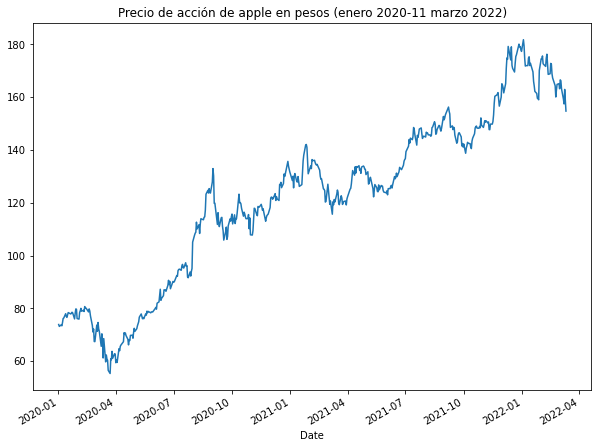

In [12]:
# vamos a graficar
apple.adj_close.plot()
plt.title('Precio de acción de apple en pesos (enero 2020-11 marzo 2022)')
plt.show()

In [13]:
#hacemos la prueba de dickey fuller aumentada ADF
adf = adfuller(apple['adj_close'])

#presentamos el p-value
print('p-value: %f' % adf[1])



p-value: 0.663041


Recuerda que $H_0$: serie no estacionaria

In [14]:
if adf[1] < 0.05:
    
    print(f'con un un p-value={adf[1].round(3)}\n Se rechaza hipótesis nula, serie estacionaria') 
    
else:
    
    print(f'con un un p-value = {adf[1].round(3)}\n NO se rechaza hipótesis nula, serie no estacionaria') 


con un un p-value = 0.663
 NO se rechaza hipótesis nula, serie no estacionaria


para hacer la serie estacionaria, usaremos lafunción shift de pandas 

y guardaremos la serie diferenciada en un objeto aparte

In [15]:
apple_diff = apple['adj_close'] - apple['adj_close'].shift()

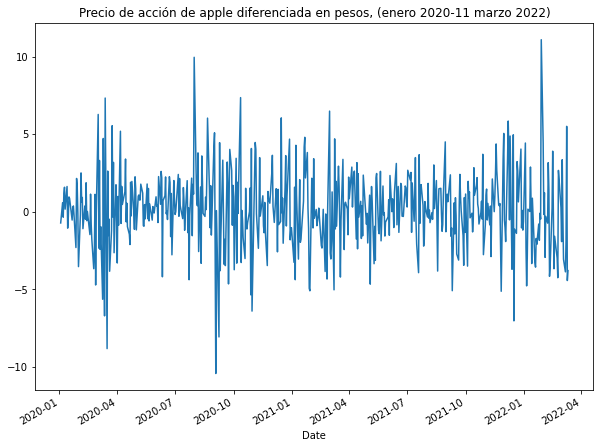

In [16]:
#graficamos el tipo de cambio diferenciado
apple_diff.plot()
plt.title('Precio de acción de apple diferenciada en pesos, (enero 2020-11 marzo 2022)')
plt.show()

In [17]:
#eliminamos los Nan
apple_diff = apple_diff.dropna()

In [18]:
## como la serie tiene saltos (los fines de semana los mercados no abren)
## removeremos la fecha
apple_diff = apple_diff.reset_index()

### eliminamos columna fecha
apple_diff = apple_diff.drop(['Date'], axis=1)

In [19]:
apple_diff

,adj_close
0,-0.718407
1,0.583084
2,-0.346886
3,1.180923
4,1.584419
...,...
547,-3.869995
548,-1.860001
549,5.509995
550,-4.429993


volvemos a realizar la prueba de raíz unitaria ADF

In [20]:
adf1 = adfuller(apple_diff)
if adf1[1] < 0.05:
    
    print(f'con un un p-value={adf1[1]}\n Se rechaza hipótesis nula, serie estacionaria') 
    
else:
    
    print(f'con un un p-value = {adf1[1]}\n NO se rechaza hipótesis nula, serie no estacionaria') 


con un un p-value=0.0
 Se rechaza hipótesis nula, serie estacionaria


Ahora que la serie ya es estacionaria, podemos hacer pronósticos con ella
por tanto debemos identificar que tipo de proceso es


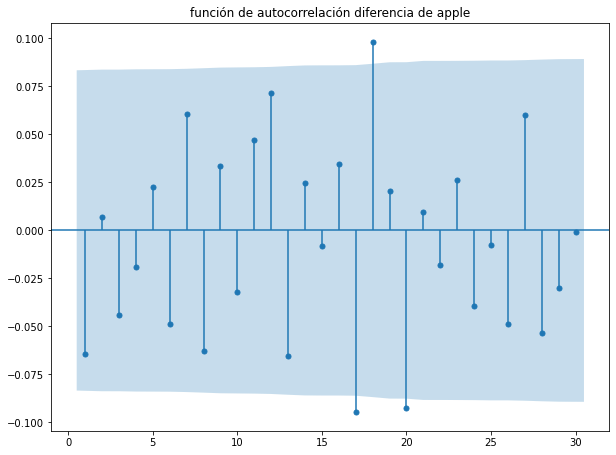

In [21]:
#grafica de autocorrelación ACF
plot_acf(apple_diff, zero=False, lags=30)
plt.title('función de autocorrelación diferencia de apple')
plt.show()

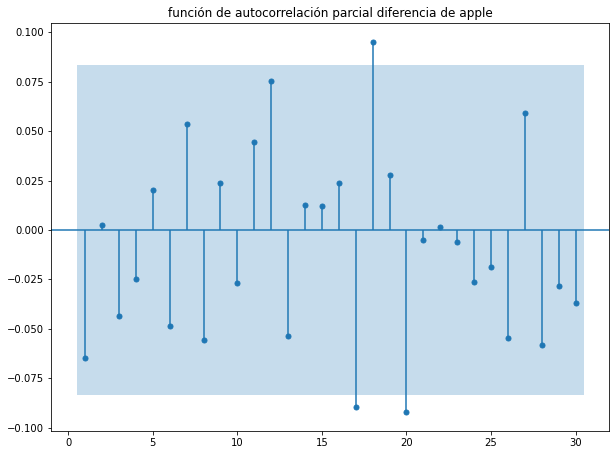

In [22]:
#grafica de autocorrelación parcial PACF
plot_pacf(apple_diff, zero=False, lags=30)
plt.title('función de autocorrelación parcial diferencia de apple')
plt.show()

nota que el primer rezago de ACF y PACF es significativo, por lo que parece que la diferencia de las acciones de apple es en ARMA (3,3) 

In [23]:
# estimamos un ARMA (3,3)
modelo = ARIMA(apple_diff, order=(3, 0, 3))
resultado = modelo.fit()
resultado.summary()

C:\Users\merry\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\merry\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\merry\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              adj_close   No. Observations:                  552
Model:                 ARIMA(3, 0, 3)   Log Likelihood               -1272.584
Date:                Sun, 13 Mar 2022   AIC                           2561.168
Time:                        16:38:37   BIC                           2595.677
Sample:                             0   HQIC                          2574.651
                                - 552                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1622      0.076      2.141      0.032       0.014       0.311
ar.L1         -0.8840      0.022    -40.355      0.000      -0.927      -0.841
ar.L2          0.8556      0.039     21.997      0.000       0.779       0.932
ar.L3          0.9836      0.021     46.742      0.000       0.942       1.025
ma.L1          0.8699      0.073     11.986      0.000       0.728       1.012
ma.L2         -0.8835      0.133     -6.640      0.000      -1.144      -0.623
ma.L3         -0.9826      0.072    -13.613      0.000      -1.124      -0.841
sigma2         5.8084      0.398     14.584      0.000       5.028       6.589
===================================================================================
Ljung-Box (L1) (Q):                   0.34   Jarque-Bera (JB):                70.31
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                             0.08
Prob(H) (two-sided):                  0.85   Kurtosis:                         4.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Note que la constante no es significativa, es decir, es cero. Pero los coeficientes de los rezagos si son significativos (distintos de cero) acuerdo con sus p-values

Aunque los ACF y PACF nos sugieren un ARMA(1,1), no son del todo precisos, asi que vamos a estimar varios modelos con 6 rezagos de AR, 6rezagos de MA y elegir uno de acuerdo con el BIC (criterio bayesiano de información)

In [24]:
ic = {}
for ar in range(7):
    for ma in range(7):
        print(f"AR: {ar}, MA: {ma}")
        modelo = ARIMA(apple_diff, order=(ar, 0, ma))
        resultado = modelo.fit()
        ic[(ar, ma)] = [resultado.aic, resultado.bic]

ic = pd.DataFrame(ic, index=["AIC", "BIC"]).T
ic.index = ic.index.set_names(["AR", "MA"])
ic

AR: 0, MA: 0
AR: 0, MA: 1
AR: 0, MA: 2
AR: 0, MA: 3
AR: 0, MA: 4
AR: 0, MA: 5
AR: 0, MA: 6
AR: 1, MA: 0
AR: 1, MA: 1
AR: 1, MA: 2
AR: 1, MA: 3
AR: 1, MA: 4
AR: 1, MA: 5
AR: 1, MA: 6
AR: 2, MA: 0
AR: 2, MA: 1


C:\Users\merry\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\merry\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AR: 2, MA: 2
AR: 2, MA: 3
AR: 2, MA: 4
AR: 2, MA: 5
AR: 2, MA: 6


C:\Users\merry\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 3, MA: 0
AR: 3, MA: 1
AR: 3, MA: 2
AR: 3, MA: 3


C:\Users\merry\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 3, MA: 4


C:\Users\merry\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 3, MA: 5


C:\Users\merry\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 3, MA: 6


C:\Users\merry\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 4, MA: 0
AR: 4, MA: 1
AR: 4, MA: 2


C:\Users\merry\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 4, MA: 3


C:\Users\merry\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 4, MA: 4


C:\Users\merry\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 4, MA: 5


C:\Users\merry\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 4, MA: 6


C:\Users\merry\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 5, MA: 0
AR: 5, MA: 1
AR: 5, MA: 2
AR: 5, MA: 3


C:\Users\merry\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 5, MA: 4


C:\Users\merry\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 5, MA: 5


C:\Users\merry\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 5, MA: 6


C:\Users\merry\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 6, MA: 0
AR: 6, MA: 1
AR: 6, MA: 2


C:\Users\merry\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 6, MA: 3


C:\Users\merry\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 6, MA: 4


C:\Users\merry\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 6, MA: 5


C:\Users\merry\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AR: 6, MA: 6


C:\Users\merry\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


AIC          BIC
AR MA                          
0  0   2571.569078  2580.196174
   1   2571.269040  2584.209684
   2   2573.268822  2590.523014
   3   2573.987952  2595.555692
   4   2575.905435  2601.786724
   5   2577.803901  2607.998737
   6   2578.898712  2613.407097
1  0   2571.262109  2584.202753
   1   2573.216918  2590.471110
   2   2574.860885  2596.428626
   3   2576.804434  2602.685722
   4   2576.102290  2606.297126
   5   2577.710529  2612.218913
   6   2578.869203  2617.691135
2  0   2573.259150  2590.513343
   1   2575.261664  2596.829404
   2   2576.504235  2602.385523
   3   2577.923046  2608.117882
   4   2579.768638  2614.277022
   5   2580.063844  2618.885777
   6   2565.145926  2608.281406
3  0   2574.220001  2595.787741
   1   2575.993854  2601.875142
   2   2577.986298  2608.181135
   3   2561.168183  2595.676567
   4   2563.245554  2602.067486
   5   2566.351927  2609.487407
   6   2565.981189  2613.430217
4  0   2575.882658  2601.763946
   1   2575.375181  2605.570017
   2   2562.571387  2597.079772
   3   2563.280860  2602.102793
   4   2561.975286  2605.110766
   5   2567.410478  2614.859506
   6   2569.349279  2621.111855
5  0   2577.649110  2607.843946
   1   2576.872595  2611.380979
   2   2579.355999  2618.177932
   3   2566.273374  2609.408855
   4   2563.835334  2611.284363
   5   2565.121770  2616.884346
   6   2570.680763  2626.756888
6  0   2578.344033  2612.852417
   1   2577.630077  2616.452010
   2   2565.058091  2608.193572
   3   2566.990444  2614.439473
   4   2570.046893  2621.809470
   5   2571.460748  2627.536873
   6   2569.353124  2629.742796

los ordenamos de acuerdo al BIC que es el indicador que voy a utilizar

In [25]:
ic.sort_values('BIC', ascending = True)

AIC          BIC
AR MA                          
0  0   2571.569078  2580.196174
1  0   2571.262109  2584.202753
0  1   2571.269040  2584.209684
1  1   2573.216918  2590.471110
2  0   2573.259150  2590.513343
0  2   2573.268822  2590.523014
   3   2573.987952  2595.555692
3  3   2561.168183  2595.676567
   0   2574.220001  2595.787741
1  2   2574.860885  2596.428626
2  1   2575.261664  2596.829404
4  2   2562.571387  2597.079772
   0   2575.882658  2601.763946
0  4   2575.905435  2601.786724
3  1   2575.993854  2601.875142
   4   2563.245554  2602.067486
4  3   2563.280860  2602.102793
2  2   2576.504235  2602.385523
1  3   2576.804434  2602.685722
4  4   2561.975286  2605.110766
   1   2575.375181  2605.570017
1  4   2576.102290  2606.297126
5  0   2577.649110  2607.843946
0  5   2577.803901  2607.998737
2  3   2577.923046  2608.117882
3  2   2577.986298  2608.181135
6  2   2565.058091  2608.193572
2  6   2565.145926  2608.281406
5  3   2566.273374  2609.408855
3  5   2566.351927  2609.487407
5  4   2563.835334  2611.284363
   1   2576.872595  2611.380979
1  5   2577.710529  2612.218913
6  0   2578.344033  2612.852417
0  6   2578.898712  2613.407097
3  6   2565.981189  2613.430217
2  4   2579.768638  2614.277022
6  3   2566.990444  2614.439473
4  5   2567.410478  2614.859506
6  1   2577.630077  2616.452010
5  5   2565.121770  2616.884346
1  6   2578.869203  2617.691135
5  2   2579.355999  2618.177932
2  5   2580.063844  2618.885777
4  6   2569.349279  2621.111855
6  4   2570.046893  2621.809470
5  6   2570.680763  2626.756888
6  5   2571.460748  2627.536873
   6   2569.353124  2629.742796

el BIC me sugiere un ARMA(1,1)

veamos que me sugiere el criterio de Akaike (AIC)

In [26]:
ic.sort_values('AIC', ascending = True)

AIC          BIC
AR MA                          
3  3   2561.168183  2595.676567
4  4   2561.975286  2605.110766
   2   2562.571387  2597.079772
3  4   2563.245554  2602.067486
4  3   2563.280860  2602.102793
5  4   2563.835334  2611.284363
6  2   2565.058091  2608.193572
5  5   2565.121770  2616.884346
2  6   2565.145926  2608.281406
3  6   2565.981189  2613.430217
5  3   2566.273374  2609.408855
3  5   2566.351927  2609.487407
6  3   2566.990444  2614.439473
4  5   2567.410478  2614.859506
   6   2569.349279  2621.111855
6  6   2569.353124  2629.742796
   4   2570.046893  2621.809470
5  6   2570.680763  2626.756888
1  0   2571.262109  2584.202753
0  1   2571.269040  2584.209684
6  5   2571.460748  2627.536873
0  0   2571.569078  2580.196174
1  1   2573.216918  2590.471110
2  0   2573.259150  2590.513343
0  2   2573.268822  2590.523014
   3   2573.987952  2595.555692
3  0   2574.220001  2595.787741
1  2   2574.860885  2596.428626
2  1   2575.261664  2596.829404
4  1   2575.375181  2605.570017
   0   2575.882658  2601.763946
0  4   2575.905435  2601.786724
3  1   2575.993854  2601.875142
1  4   2576.102290  2606.297126
2  2   2576.504235  2602.385523
1  3   2576.804434  2602.685722
5  1   2576.872595  2611.380979
6  1   2577.630077  2616.452010
5  0   2577.649110  2607.843946
1  5   2577.710529  2612.218913
0  5   2577.803901  2607.998737
2  3   2577.923046  2608.117882
3  2   2577.986298  2608.181135
6  0   2578.344033  2612.852417
1  6   2578.869203  2617.691135
0  6   2578.898712  2613.407097
5  2   2579.355999  2618.177932
2  4   2579.768638  2614.277022
   5   2580.063844  2618.885777

criterio de AIC tambien me sugiere ARMA (3,3)

In [27]:
# estimamos un ARMA (3,3)
modelo = ARIMA(apple_diff, order=(3, 0, 3))
resultado = modelo.fit()
resultado.summary()

C:\Users\merry\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\merry\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\merry\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              adj_close   No. Observations:                  552
Model:                 ARIMA(3, 0, 3)   Log Likelihood               -1272.584
Date:                Sun, 13 Mar 2022   AIC                           2561.168
Time:                        16:45:26   BIC                           2595.677
Sample:                             0   HQIC                          2574.651
                                - 552                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1622      0.076      2.141      0.032       0.014       0.311
ar.L1         -0.8840      0.022    -40.355      0.000      -0.927      -0.841
ar.L2          0.8556      0.039     21.997      0.000       0.779       0.932
ar.L3          0.9836      0.021     46.742      0.000       0.942       1.025
ma.L1          0.8699      0.073     11.986      0.000       0.728       1.012
ma.L2         -0.8835      0.133     -6.640      0.000      -1.144      -0.623
ma.L3         -0.9826      0.072    -13.613      0.000      -1.124      -0.841
sigma2         5.8084      0.398     14.584      0.000       5.028       6.589
===================================================================================
Ljung-Box (L1) (Q):                   0.34   Jarque-Bera (JB):                70.31
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                             0.08
Prob(H) (two-sided):                  0.85   Kurtosis:                         4.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

En realidad, en este caso, como diferenciamos una vez la serie de tiempo estacionaria para hacerla estacionaria, nuestro modelo ARMA (1,1), es un ARIMA(1,1,1) de la serie original

In [28]:
# estimamos un ARIMA (3,3)
modelo2 = ARIMA(apple['adj_close'], order=(3, 1, 3))
resultado2 = modelo2.fit()
resultado2.summary()

C:\Users\merry\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\merry\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\merry\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\merry\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive paramet

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              adj_close   No. Observations:                  553
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -1274.529
Date:                Sun, 13 Mar 2022   AIC                           2563.059
Time:                        16:46:07   BIC                           2593.253
Sample:                             0   HQIC                          2574.856
                                - 553                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8933      0.347     -2.576      0.010      -1.573      -0.214
ar.L2          0.8426      0.650      1.296      0.195      -0.432       2.117
ar.L3          0.9755      0.346      2.819      0.005       0.297       1.654
ma.L1          0.9000      0.357      2.521      0.012       0.200       1.600
ma.L2         -0.8477      0.669     -1.267      0.205      -2.159       0.464
ma.L3         -0.9732      0.355     -2.745      0.006      -1.668      -0.278
sigma2         5.8884      0.284     20.712      0.000       5.331       6.446
===================================================================================
Ljung-Box (L1) (Q):                   0.62   Jarque-Bera (JB):                73.81
Prob(Q):                              0.43   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             0.04
Prob(H) (two-sided):                  0.80   Kurtosis:                         4.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [29]:
# vamos a estimar la serie con el modelo ARIMA
apple['pronostico'] = resultado2.predict()
apple['pronostico'][0] = apple['adj_close'][0]

C:\Users\merry\AppData\Local\Temp/ipykernel_9716/3131426077.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple['pronostico'][0] = apple['adj_close'][0]


graficamos la y_estimada con la y_original

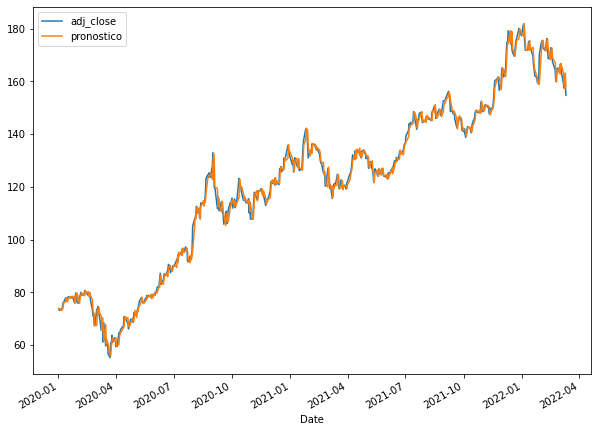

In [30]:
apple[['adj_close', 'pronostico']].plot()
plt.show()

In [31]:
#calculamos cuantas observaciones tenemos para hacer nuestra predicción
len(apple)

553

la función len nos arrojo que tenemos 553 observaciones,  quiere decir que el lunes sería la observación 554, el martes la 555, y el miércoles la 556

In [32]:
## vamos a pronosticar esos días
resultado2.predict(554, 556)

C:\Users\merry\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


554    154.703316
555    155.082189
556    154.775686
Name: predicted_mean, dtype: float64

mi pronostico para el lunes 14 de marzo es que la acción de walmart tenga un precio de cierre (ajustado) de 154.703316

El viernes cerro en 154.73